In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from io import StringIO
from sklearn.preprocessing import MaxAbsScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import FactorAnalysis
import matplotlib.pyplot as plt
from IPython.display import clear_output
from beamngpy import BeamNGpy, Scenario, Vehicle
from beamngpy.sensors import Electrics
import keyboard
import time

def millis():
    return time.time_ns() / 1000000
oldtime = millis()
curtime = 0
rectime = 0
step = 1/60 * 1000 #60 hz

## Lectura de datos

In [2]:
# Leer carpeta
CARPETA = "datos_cluster2d"
datos = False
columnas = [
    # Comandos
    "throttle_input",
    "brake_input",
    "clutch_input",
    "steering_input",
    "gear",
    # Estado
    "rpm",
    "airspeed"
]
files = Path(CARPETA).glob('*')
for i, ruta in enumerate(files):
    df = pd.read_csv(ruta, usecols=columnas)
    if (i == 0):
        datos = df
    else:
        datos = pd.concat([datos, df])
datos = datos.sort_index(axis=1)
display(datos)

,airspeed,brake_input,clutch_input,gear,rpm,steering_input,throttle_input
0,0.000151,0.0,0.0,0.0,670.807550,0.0,0.0
1,0.000133,0.0,0.0,0.0,667.582291,0.0,0.0
2,0.000143,0.0,0.0,0.0,664.387431,0.0,0.0
3,0.000144,0.0,0.0,0.0,661.140019,0.0,0.0
4,0.000142,0.0,0.0,0.0,664.203268,0.0,0.0
...,...,...,...,...,...,...,...
19117,5.631616,0.0,0.0,3.0,677.509226,0.0,0.0
19118,4.615105,0.0,0.0,3.0,671.776655,0.0,0.0
19119,3.722385,0.0,0.0,3.0,662.908032,0.0,0.0
19120,3.067817,0.0,0.0,3.0,653.631925,0.0,0.0


## Normalización y reducción de dimensionalidad

In [3]:
scaler = MaxAbsScaler().fit(datos)
X_scaled = scaler.transform(datos)
pca = PCA(n_components=2)
X_p = pca.fit_transform(X_scaled)

fa = FactorAnalysis(n_components=2)
X_f = fa.fit_transform(X_scaled)

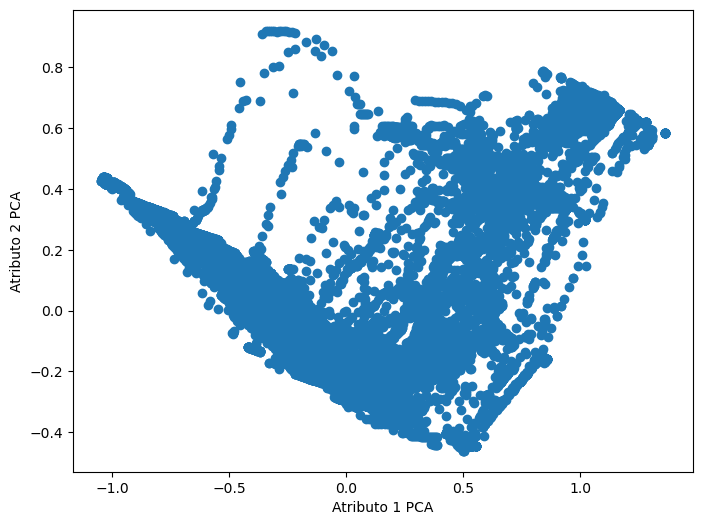

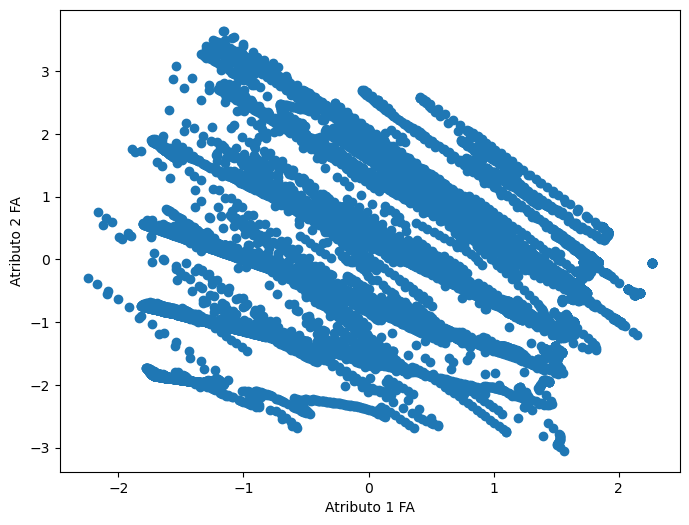

In [4]:
fig = plt.figure()
fig.set_size_inches(8,6)
ax = fig.add_subplot()
ax.scatter(X_p[:, 0], X_p[:, 1])
ax.set_xlabel("Atributo 1 PCA"), ax.set_ylabel("Atributo 2 PCA")
plt.show()

fig = plt.figure()
fig.set_size_inches(8,6)
ax = fig.add_subplot()
ax.scatter(X_f[:, 0], X_f[:, 1])
ax.set_xlabel("Atributo 1 FA"), ax.set_ylabel("Atributo 2 FA")
plt.show()

## Observar reducción

In [5]:
bng_path = "C:\Program Files (x86)\Steam\steamapps\common\BeamNG.drive"
bng = BeamNGpy('localhost', 64256, home=bng_path)
bng.open()

In [6]:
scenario = Scenario('west_coast_usa', 'ml_beamng')
vehicle = Vehicle('veh', model='pessima', licence='HOLA')
electrics = Electrics()
vehicle.attach_sensor("electrics", electrics)
scenario.add_vehicle(vehicle, pos=(-717, 101, 118), rot_quat=(0, 0, 0.3826834, 0.9238795))
scenario.make(bng)
bng.load_scenario(scenario)
bng.start_scenario()
vehicle.set_shift_mode("realistic_manual")

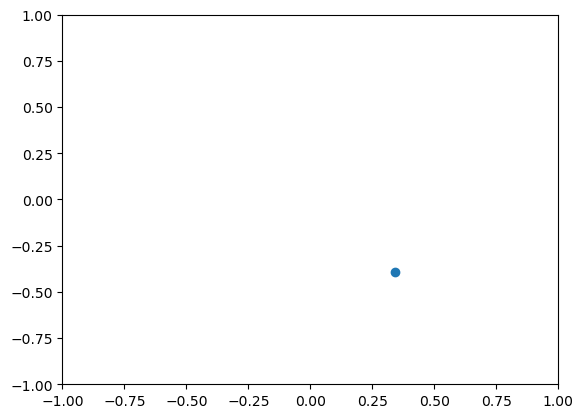

In [7]:
def lectura_sensores():
    vehicle.poll_sensors()
    keys = ""
    val = ""
    for i, data in enumerate(electrics.data.items()):
        if (i > 0):
            keys = keys + ","
            val = val + ","
        if (data[0] == "wheelThermals"):
            continue
        keys = keys + str(data[0])
        val = val + str(data[1])
    return keys + '\n' + val

fig = plt.figure()
ax = fig.add_subplot()
while True:
    if (keyboard.is_pressed('D')):
        break
    #actualizar valor
    curtime = millis()
    if curtime > (oldtime + step):
        oldtime = curtime
        x = pd.read_csv(StringIO(lectura_sensores()), usecols=columnas).sort_index(axis=1)
        x_scaled = scaler.transform(x)
        x_p = pca.transform(x_scaled)
        x_f = fa.transform(x_scaled)
        ax.clear()
        ax.set_xlim(-1, 1)
        ax.set_ylim(-1, 1)
        ax.scatter(x_p[0,0], x_p[0,1])
        display(fig)
        clear_output(wait = True)